# Project Overview

Figuring out how well energy efficiency upgrades work in buildings isn’t easy. Since we can’t directly measure how much energy a building would have used without the upgrades, we use counterfactual models instead. These models estimate what energy use would have been without the improvements, helping us determine the actual savings. The more accurate these models are, the better the market incentives and the cheaper the financing for future upgrades.

## Objective

This project aims to create predictive models that estimate a building's energy use before and after upgrades. These models will help assess how well energy efficiency improvements work for four types of energy: electricity, chilled water, steam, and hot water. By making the models more accurate, we can support smarter financial decisions and get the most out of energy efficiency investments.

## Dataset Description

The dataset consists of three years of hourly meter readings from over one thousand buildings located at various sites worldwide. It includes three key components:

1. Energy Consumption Data (train.csv)

   - building_id: Identifier for each building.

   - meter: Type of energy meter (0: electricity, 1: chilled water, 2: steam, 3: hot water).

   - timestamp: Date and time of the measurement.

   - meter_reading: Actual energy consumption (in kWh or equivalent).

Note: Data may contain measurement errors, setting a baseline level of modeling uncertainty.

2. Building Metadata (building_meta.csv)

   - site_id: Links buildings to weather data.

   - building_id: Links metadata to energy consumption data.

   - primary_use: Indicates the primary function of the building (e.g., office, hospital, retail, etc.).

   - square_feet: Total floor area of the building.

   - year_built: Year the building was constructed.

   - floor_count: Number of floors in the building.

3. Weather Data (weather_train.csv & weather_test.csv)

    Weather conditions from meteorological stations near the building sites:

   - site_id: Identifier linking weather data to buildings.

   - air_temperature: Temperature in degrees Celsius.

   - cloud_coverage: Sky cloud coverage in oktas.

   - dew_temperature: Dew point temperature in degrees Celsius.

   - precip_depth_1_hr: Rainfall in millimeters.

   - sea_level_pressure: Atmospheric pressure in millibars.

   - wind_direction: Wind direction in degrees (0-360).

   - wind_speed: Wind speed in meters per second.

## Methodology

To develop effective counterfactual models, we will employ the following machine learning techniques:

Data Preprocessing

Handle missing values in weather and building metadata.

Convert timestamps to meaningful features (e.g., hour, day of the week, seasonality).

Normalize and scale numeric features.

Feature Engineering

Model Selection and Training

Experiment with multiple machine learning algorithms:

Gradient Boosting Models (XGBoost, LightGBM, CatBoost): Handle non-linearity and feature interactions well.

Neural Networks: Capture complex temporal dependencies in energy consumption.

Train models on historical data and validate using recent data to ensure generalization.

Model Evaluation

Compare model predictions with actual post-retrofit energy usage.

Deployment & Interpretation

Deploy the best-performing model to estimate energy savings.

Provide insights on key factors influencing energy efficiency (e.g., weather conditions, building age, usage type).

Develop visualizations to communicate results effectively to stakeholders.

## Conclusion

This project is all about connecting real-world energy upgrades with their financial benefits. By using machine learning, we can offer data-driven insights that make it easier to invest in sustainable energy solutions—helping pave the way for a more energy-efficient future.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## EDA and pre-processing

In [2]:
train = pd.read_csv('data/train.csv')
building_metadata = pd.read_csv('data/building_metadata.csv')
weather = pd.read_csv('data/weather_train.csv')

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


#### **Step 1**: Merge between train and building_metadata

building_metadata contain building_id so we will merge on that first.

In [3]:
df = train.merge(building_metadata, on='building_id', how='left')


In [7]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


#### **Step 2**: Merge df with weather_train

The weather_train.csv dataset contains site_id and timestamp, so we need to merge using these keys.

We need to ensure timestamp is in datetime format before merging to avoid mismatches.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


#### **Step 3**: Understanding the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int64         
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 2.4+ GB


The memory usage of this dataset is quite large so we use a more memory-efficient data type:


In [5]:
# Downcast numerical columns to save memory
df['primary_use'] = df['primary_use'].astype('category') # This line is the more important one, it divide by 100 the memory used
df['building_id'] = df['building_id'].astype('int32')
df['meter'] = df['meter'].astype('int32')
df['site_id'] = df['site_id'].astype('int32')
df['square_feet'] = df['square_feet'].astype('int32')
df['year_built'] = df['year_built'].astype('float32')  
df['floor_count'] = df['floor_count'].astype('float32')
df['meter_reading'] = df['meter_reading'].astype('float32')
df['air_temperature'] = df['air_temperature'].astype('float32')
df['cloud_coverage'] = df['cloud_coverage'].astype('float32')
df['dew_temperature'] = df['dew_temperature'].astype('float32')
df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
df['wind_direction'] = df['wind_direction'].astype('float32')
df['wind_speed'] = df['wind_speed'].astype('float32')

# Check the memory usage
print(df.memory_usage(deep=True))

Index                       132
building_id            80864400
meter                  80864400
timestamp             161728800
meter_reading          80864400
site_id                80864400
primary_use            20217659
square_feet            80864400
year_built             80864400
floor_count            80864400
air_temperature        80864400
cloud_coverage         80864400
dew_temperature        80864400
precip_depth_1_hr      80864400
sea_level_pressure     80864400
wind_direction         80864400
wind_speed             80864400
dtype: int64


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int32         
 1   meter               int32         
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int32         
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float32       
 8   floor_count         float32       
 9   air_temperature     float32       
 10  cloud_coverage      float32       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float32       
 13  sea_level_pressure  float32       
 14  wind_direction      float32       
 15  wind_speed          float32       
dtypes: category(1), datetime64[ns](1), float32(10), int32(4)
memory usage: 1.2 GB


In [12]:
print(df.shape)

(20216100, 16)


In [13]:
df.describe()

,building_id,meter,timestamp,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,20216100,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2016-07-03 22:59:40.301601792,2.117122e+03,7.992232e+00,1.077830e+05,1.968276e+03,4.184848e+00,1.598795e+01,1.900424e+00,7.747426e+00,7.964156e-01,1.016085e+03,1.730152e+02,3.377523e+00
min,0.000000e+00,0.000000e+00,2016-01-01 00:00:00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,2016-04-05 21:00:00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,2016-07-04 17:00:00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2016-10-02 22:00:00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2016-12-31 23:00:00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01
std,4.269133e+02,9.309921e-01,NaN,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00


#### **Step 4**: Null values

Next, we check if there are any null values in our dataset.

In [14]:
df.isnull().sum().sort_values(ascending=False)

floor_count           16709167
year_built            12127645
cloud_coverage         8825365
precip_depth_1_hr      3749023
wind_direction         1449048
sea_level_pressure     1231669
wind_speed              143676
dew_temperature         100140
air_temperature          96658
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
dtype: int64

We can see that a lot of our columns have missing values. We need to handle them properly because it could impact our model's performance later on.
The good news is that there are no missing values in our target variable: meter_reading.

In [15]:
display((df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False))

floor_count           82.652772
year_built            59.990033
cloud_coverage        43.655131
precip_depth_1_hr     18.544739
wind_direction         7.167792
sea_level_pressure     6.092515
wind_speed             0.710701
dew_temperature        0.495348
air_temperature        0.478124
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
dtype: float64

In [16]:
# we drop all the columns with more than 40% missing values

# df = df.drop(['cloud_coverage', 'year_built', 'floor_count'], axis=1)

In [6]:
# fill missing values with knn imputer or mean for efficiency
from sklearn.impute import KNNImputer


df_numeric = df.select_dtypes(exclude=['object', 'datetime64[ns]','category']) 
df_non_numeric = df.select_dtypes(include=['object', 'datetime64[ns]', 'category'])  
# method = 'knn'
method = 'mean'

if method == 'knn':
    batch_size=1000
    knn_imputer = KNNImputer(n_neighbors=3)
    df_imputed_list=[]
    columns = df_numeric.columns 

    for i in range(0, len(df_numeric), batch_size):
        batch = df_numeric.iloc[i:i+batch_size]

        if batch.isnull().all().all():
            imputed_batch = batch.fillna(0).values 
        else:
            imputed_batch = knn_imputer.fit_transform(batch)

        df_imputed_list.append(pd.DataFrame(imputed_batch, columns=columns[:imputed_batch.shape[1]]))  

    df_imputed = pd.concat(df_imputed_list, axis=0).reset_index(drop=True)

    df_imputed = pd.concat(df_imputed_list, axis=0).reset_index(drop=True)

    # Add back the datetime column
    df_imputed['date'] = df['date'].values


elif method == 'mean': 
    df_imputed = df_numeric.fillna(df_numeric.mean())

df_final = pd.concat([df_imputed, df_non_numeric.reset_index(drop=True)], axis=1)
df=df_final
df.head()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp,primary_use
0,0,0,0.0,0,7432,2008.0,4.184848,25.0,6.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
1,1,0,0.0,0,2720,2004.0,4.184848,25.0,6.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
2,2,0,0.0,0,5376,1991.0,4.184848,25.0,6.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
3,3,0,0.0,0,23685,2002.0,4.184848,25.0,6.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
4,4,0,0.0,0,116607,1975.0,4.184848,25.0,6.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education


In [18]:
df.isnull().sum().sort_values(ascending=False)

building_id           0
meter                 0
meter_reading         0
site_id               0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
timestamp             0
primary_use           0
dtype: int64

#### **Step 5**: Check the duplicates

We also want to make sure there are no duplicates in the dataset.

In [19]:
df.shape

(20216100, 16)

In [7]:
df=df.drop_duplicates()

In [21]:
df.shape

(20216100, 16)

The number of rows hasn't changed so that means there were no duplicates.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int32         
 1   meter               int32         
 2   meter_reading       float32       
 3   site_id             int32         
 4   square_feet         int32         
 5   year_built          float32       
 6   floor_count         float32       
 7   air_temperature     float32       
 8   cloud_coverage      float32       
 9   dew_temperature     float32       
 10  precip_depth_1_hr   float32       
 11  sea_level_pressure  float32       
 12  wind_direction      float32       
 13  wind_speed          float32       
 14  timestamp           datetime64[ns]
 15  primary_use         category      
dtypes: category(1), datetime64[ns](1), float32(10), int32(4)
memory usage: 1.2 GB


#### **Step 6**: Detect and replace the outliers

In this step, we identify and handle extreme values (aka outliers) in our dataset to keep things balanced. We use the Interquartile Range (IQR) method, which helps detect unusually high or low values that might alter or bias our analysis. Instead of removing these outliers (which could mean losing valuable data), we cap them by replacing values that fall outside the normal range with the closest acceptable limit (the 1st quartile or the 3rd). This ensures our data stays clean and reliable while preserving its overall structure.

In [8]:
outlier_cols = ['square_feet', 'air_temperature', 'dew_temperature', 
                'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

def replace_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data.apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

df[outlier_cols] = df[outlier_cols].apply(replace_outliers) 

#### **Step 7**: Feature engineering

**Time Features**:

We want to separate the date from the time. This way it will be easier to manipulate the dataset when we want to analyse things hourly or daily or monthly.

For the hour, we only take the first part because the data is always taken at full hours like 9:00 or 21:00.

We also are decomposing the date into day, month and year which will make things easier when we need to filter data based on timestamps.

For the day, we also use dt.dayoftheweek to get a value depending on the date: 1 for Monday, 2 for Tuesday, etc. The specific day number (like the 10th or the 23rd) is not necessarily important. Something that would be more relevant is knowing if it is a Monday, Tuesday, etc., and then whether it's a weekday or weekend.
Once we have this, we can determine if the day is a week day or weekend: if the number is between 1 and 5 it's the week and if the number is 6 or 7, it's the weekend.

In [9]:
df['date']=df['timestamp'].dt.date.astype('datetime64[ns]')
df['hour'] = df['timestamp'].dt.hour
df['year']=df['timestamp'].dt.year
df['month']=df['timestamp'].dt.month
df['day']=df['timestamp'].dt.day
df["weekend"] = df["timestamp"].dt.weekday
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df=df.drop('timestamp', axis=1)
df.head()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,...,wind_speed,primary_use,date,hour,year,month,day,weekend,dayofweek,is_weekend
0,0,0,0.0,0,7432.0,2008.0,4.184848,25.0,6.0,20.0,...,0.0,Education,2016-01-01,0,2016,1,1,4,4,0
1,1,0,0.0,0,2720.0,2004.0,4.184848,25.0,6.0,20.0,...,0.0,Education,2016-01-01,0,2016,1,1,4,4,0
2,2,0,0.0,0,5376.0,1991.0,4.184848,25.0,6.0,20.0,...,0.0,Education,2016-01-01,0,2016,1,1,4,4,0
3,3,0,0.0,0,23685.0,2002.0,4.184848,25.0,6.0,20.0,...,0.0,Education,2016-01-01,0,2016,1,1,4,4,0
4,4,0,0.0,0,116607.0,1975.0,4.184848,25.0,6.0,20.0,...,0.0,Education,2016-01-01,0,2016,1,1,4,4,0


**Seasonal Features**: Consumption is affected by weather and seasonality. We can create a season column based on month:

In [10]:
def get_season(month):
    if month in [12, 1, 2]:  return 'winter'
    elif month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    else: return 'fall'

df['season'] = df['month'].apply(get_season)


**Temperature-Based Features**: If air_temperature affects usage, we can define hot vs cold days:

In [11]:
df['is_hot_day'] = (df['air_temperature'] > df['air_temperature'].quantile(0.75)).astype(int)
df['is_cold_day'] = (df['air_temperature'] < df['air_temperature'].quantile(0.25)).astype(int)


#### **Step 8**: Ensuring there are no negative values in the target variable
Now we also want to make sure there are no negative meter readings as that would be impossible.

In [27]:
print(df['meter_reading'].describe())

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64


In [28]:
print(df['meter_reading'].min())

0.0


We can see that the minimum value is 0.0 so there are no mistakes.

#### **Step 9**: Time Cyclic Encoding

We will use Time Cyclic Encoding using sine and cosine transformations to handle the cyclical nature of the time-based features such as hour, dayofweek and month.

Many machine learning models (like linear regression and tree-based models) assume that values have a linear relationship meaning that larger values are more important. But time-based variables don't behave that way. For example, the hour feature goes from 0 to 23, but 23:00 is just one hour away from 0:00 (midnight), which is not far apart. Similarly, dayofweek runs from 0 (Monday) to 6 (Sunday), but Sunday (6) is right next to Monday (0).

If we just feed these numbers into a model, it might think that 23 is much bigger than 0, when in reality, they are close in time. To fix this, we use sine and cosine transformations to map these values onto a circular space. By doing this, values that are close in time remain close mathematically (e.g., hour 23 and hour 0 will have similar encoded values) and the model will capture cyclical patterns more effectively.

In [12]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [30]:
df.head()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,...,is_weekend,season,is_hot_day,is_cold_day,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,0,0,0.0,0,7432.0,2008.0,4.184848,25.0,6.0,20.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
1,1,0,0.0,0,2720.0,2004.0,4.184848,25.0,6.0,20.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
2,2,0,0.0,0,5376.0,1991.0,4.184848,25.0,6.0,20.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
3,3,0,0.0,0,23685.0,2002.0,4.184848,25.0,6.0,20.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
4,4,0,0.0,0,116607.0,1975.0,4.184848,25.0,6.0,20.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025


## Visualizations

### 1-General Consumption Trends and Correlations

**Overall Energy Consumption Over Time**

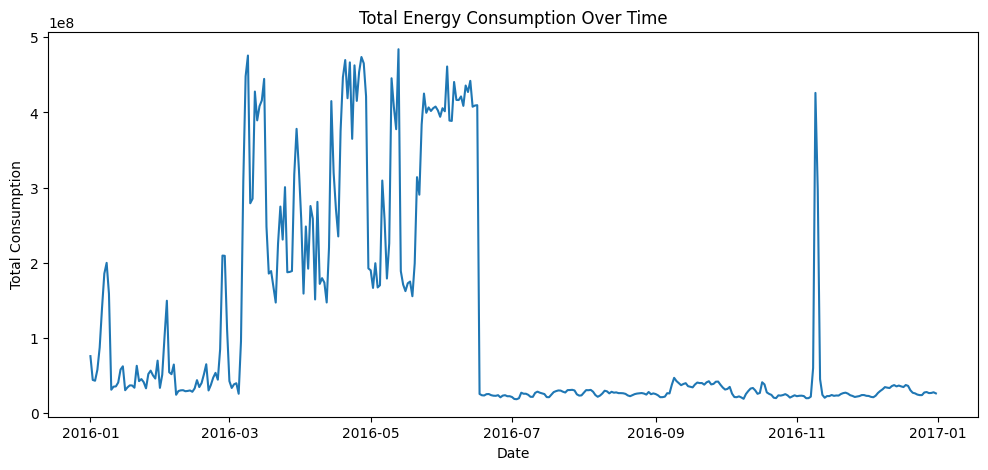

In [31]:
df_daily = df.groupby('date')['meter_reading'].sum().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_daily['date'], y=df_daily['meter_reading'])
plt.title('Total Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.show()

This line chart shows the total energy consumption over time (in a year) and we can see huge fluctuations in energy usage. At the beginning of 2016, energy consumption has a gradual increase, and then it has sharp spikes between March and May where it goes up and down a lot. Then, a significant drop happens around mid-2016, where consumption levels remain low pretty consistently for the rest of the year, except for a sudden peak in November. It is very strange that the energy has a sudden drop for a very long period of the year except in November. This could either mean that there were some issues when the data was collected.

**Hourly Energy Consumption by Building Type**

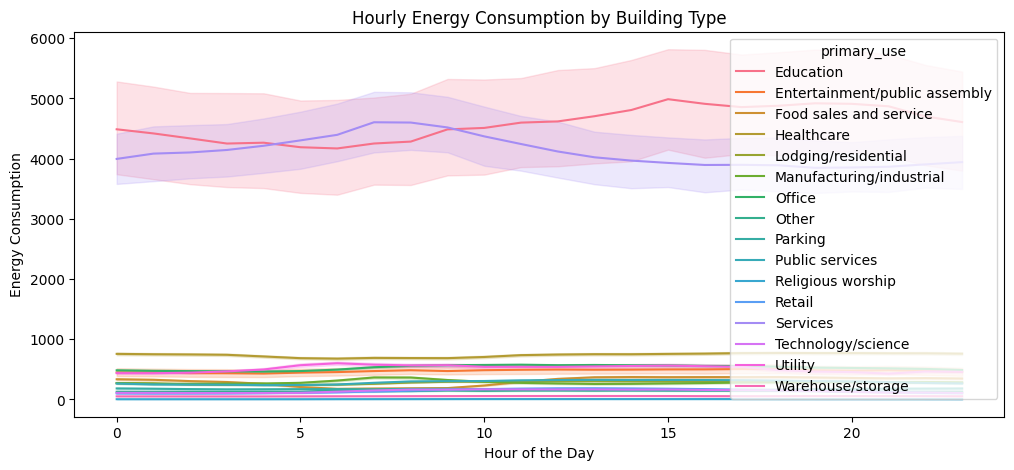

In [32]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['hour'], y=df['meter_reading'], hue=df['primary_use'], estimator='mean')
plt.title('Hourly Energy Consumption by Building Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.show()

This line chart shows the average hourly energy consumption across different building types. We can see that certain categories, like as Education and Services have much higher energy usage throughout the day compared to others. While most building types have relatively stable consumption patterns, some have more noticeable fluctuations, which could be influenced by operational hours. For example, for Services there is an increase around 7am while for Education, the peak is around 3pm. The great difference in energy consumption could suggest that different buildings have unique energy demands, with some peaking during specific hours. We also have some shaded regions that indicate that there is variability and that some categories have more fluctuation in energy usage than others.

**Average Energy Consumption in a Day**

C:\Users\lorra\AppData\Local\Temp\ipykernel_30044\2513089811.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)


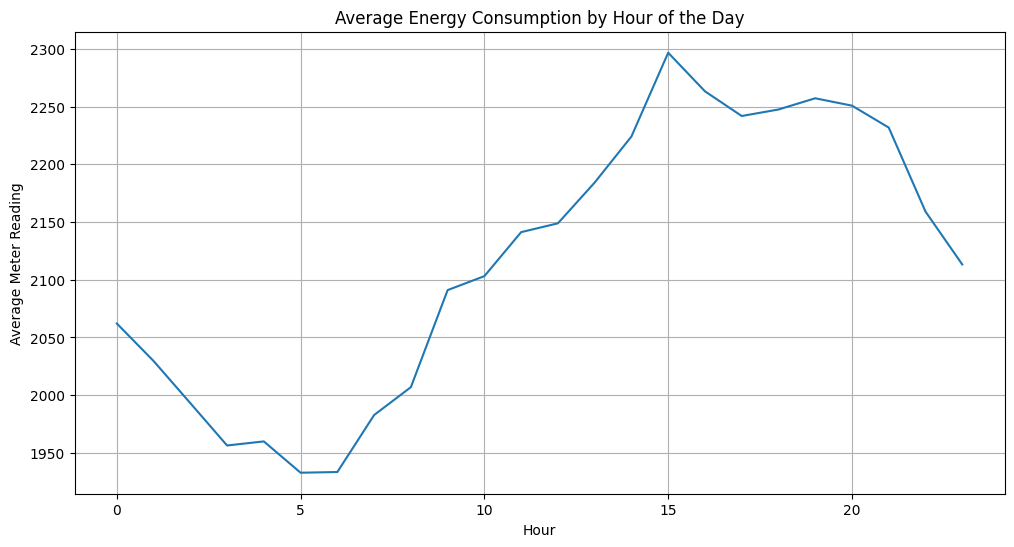

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)
plt.title('Average Energy Consumption by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Meter Reading')
plt.grid()
plt.show()


This line chart shows the average energy consumption by hour of the day, and this can give us insights into how energy usage changes throughout the day.  It's pretty clear that energy consumption is at its lowest during the early morning hours, hitting a low point around 4 AM to 5 AM. As the day goes on, energy use steadily climbs, peaking sharply around 6 PM, which is probably when most people are home from work or school and using more appliances and lights. After this peak, energy use starts to drop but stays relatively high until around 10 PM, before falling off more significantly. There are big spikes during busy times and they drop during quieter hours.

**Monthly Energy Consumption**

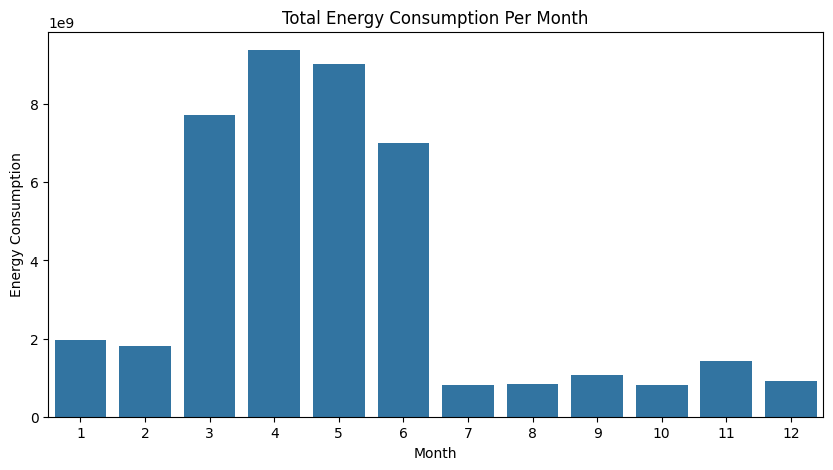

In [34]:
df_monthly = df.groupby('month')['meter_reading'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=df_monthly['month'], y=df_monthly['meter_reading'])
plt.title('Total Energy Consumption Per Month')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.show()

This bar chart shows the total energy consumption for each month of the year, giving us a clear view of how energy use changes throughout the year. It's pretty obvious that the middle of the year, particularly from March to June, sees the highest energy consumption, with a significant peak in April and May. These months might be when heating or cooling demands are highest, depending on the climate.

In contrast, the early months of the year, like January and February, and the later months, like July to December, show much lower energy usage. This pattern suggests that seasonal factors play a big role in energy consumption, with certain months requiring much more energy due to weather conditions or other seasonal activities. 

Much like the first graph, it is peculiar that there is such a big drop after June.

**Total Energy Consumption by Energy Source**

C:\Users\lorra\AppData\Local\Temp\ipykernel_30044\1207286170.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}),


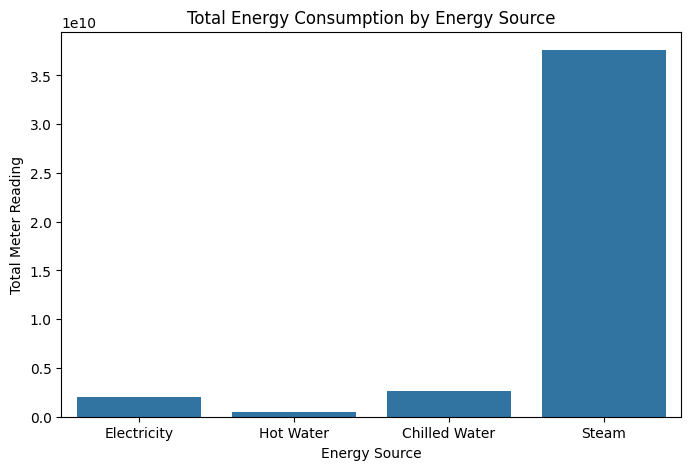

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}), 
            y=df['meter_reading'], estimator=sum, ci=None)
plt.title('Total Energy Consumption by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Total Meter Reading')
plt.show()


This bar chart represents the total energy consumption for different energy sources, which are Electricity, Hot Water, Chilled Water, and Steam. We can see that Steam has the highest energy consumption by a lot. Electricity and Chilled Water have comparable consumption levels, although they both are significantly lower than Steam. Hot Water is the one with the least total consumption among all the sources. this could indicate either that it is the main source of energy for most buildings or that it's the less efficient source (meaning that a lot of energy needs to be used to confortably make the building "work").

**Correlation Heatmap**

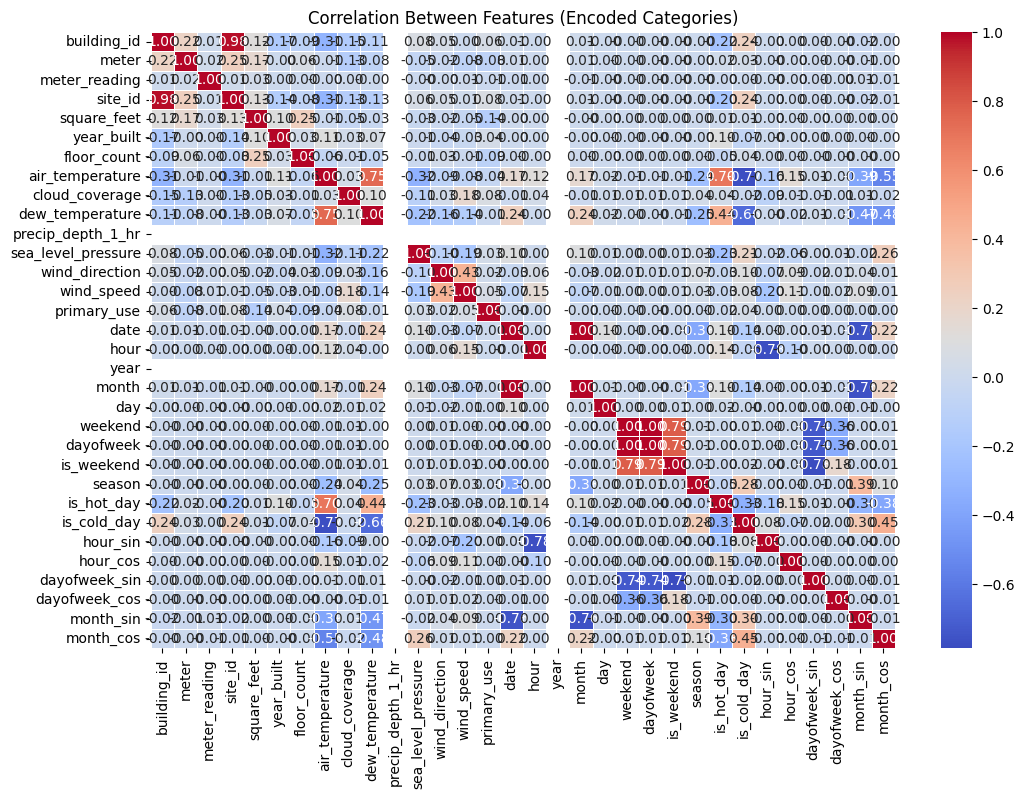

In [37]:
df_encoded = df.copy()
label_encoders = {}

for col in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Features (Encoded Categories)')
plt.show()

This heatmap visualizes the correlation between various features in the dataset after encoding categorical variables. The color intensity and numbers in the grid represent the strength and direction of the correlation between each pair of features.

- **Air Temperature and Dew Temperature**: they show a strong positive correlation, indicating that as air temperature increases, dew temperature tends to increase as well.

- **Sea Level Pressure and Wind Speed**: there is a negative correlation between these features, suggesting that higher sea level pressure is associated with lower wind speeds.

- **Temporal Features**: we see correlations between temporal features like hour, month, and day of the week. For example, the hour of the day shows some correlation with air temperature, which makes sense as temperatures vary throughout the day.

- **Building Characteristics**: features like square footage and year built show some correlation with energy consumption, indicating that building size and age might influence energy usage patterns.


### 2-Weather Impact on Energy Consumption

**Temperature vs. Energy Consumption**

C:\Users\lorra\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


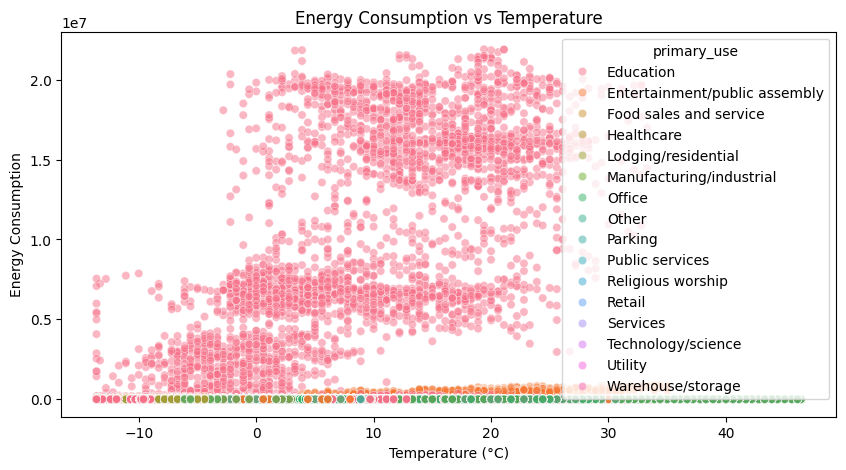

In [38]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['air_temperature'], y=df['meter_reading'], hue=df['primary_use'], alpha=0.5)
plt.title('Energy Consumption vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy Consumption')
plt.show()


This graph shows how energy consumption varies with temperature across different building types. It seems that buildings used for education and entertainment/public assembly tend to have higher energy consumption, especially as temperatures become more extreme but especially Education. This suggests these buildings have significant heating and cooling demands. However, the other buildings show very low energy usage, which could indicate different operational needs or better energy efficiency. The plot also highlights that both very low and very high temperatures lead to increased energy consumption, emphasizing the impact of weather on energy use across various building types.

**Precipitation Impact on Energy Consumption**

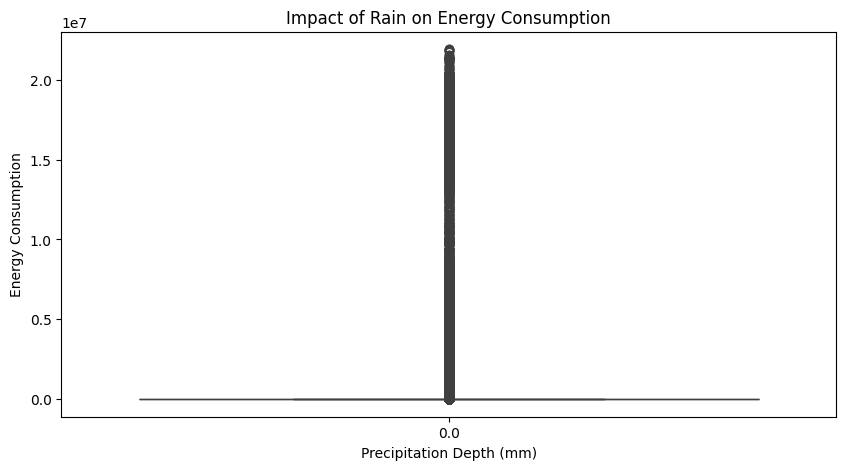

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['precip_depth_1_hr'], y=df['meter_reading'])
plt.title('Impact of Rain on Energy Consumption')
plt.xlabel('Precipitation Depth (mm)')
plt.ylabel('Energy Consumption')
plt.show()


With this graph, we study the impact of rain on energy consumption by comparing precipitation depth with energy usage. The plot shows that there is no precipitation ever, as we can see by the concentration of data points at 0 mm. We can't really know the impact of rain with this dataset unfortunately.

**Wind Speed vs. Energy Usage**

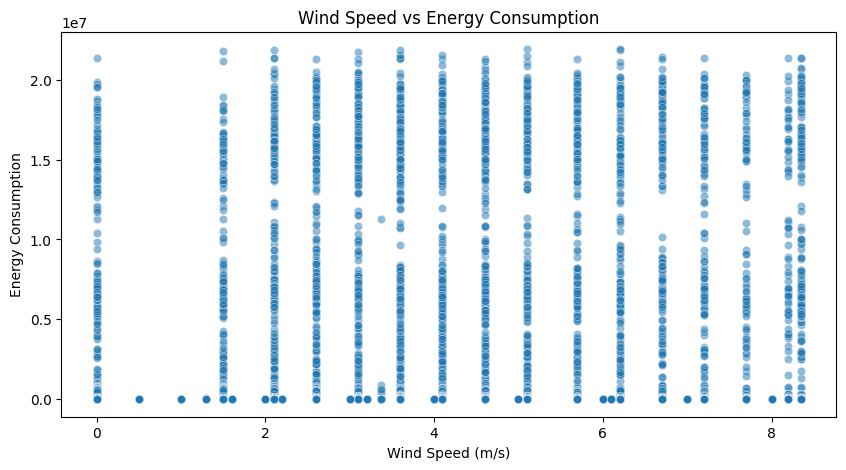

In [40]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['wind_speed'], y=df['meter_reading'], alpha=0.5)
plt.title('Wind Speed vs Energy Consumption')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Energy Consumption')
plt.show()


This graph shows the relationship between wind speed and energy consumption. The data points are spread across various wind speeds, from 0 to about 8 meters per second, with energy consumption levels varying significantly. There isn't a strong linear relationship between wind speed and energy consumption, as the data points are dispersed across the plot. This plot shows that while wind speed may have some impact, it is likely part of a more complex interaction of factors affecting energy consumption.

### 3-Building-Level Analysis

**Top 10 Buildings with the Highest Energy Consumption**

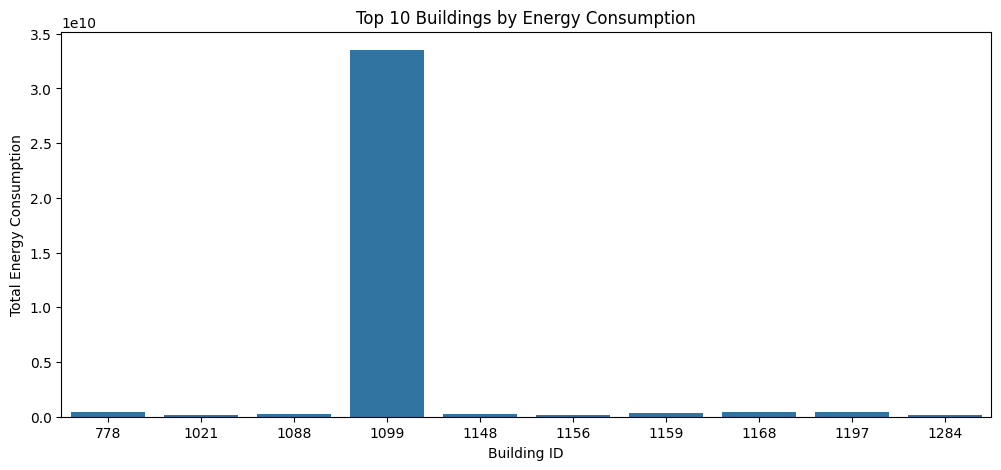

In [41]:
top_10_buildings = df.groupby('building_id')['meter_reading'].sum().nlargest(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_10_buildings.index, y=top_10_buildings.values)
plt.title('Top 10 Buildings by Energy Consumption')
plt.xlabel('Building ID')
plt.ylabel('Total Energy Consumption')
plt.show()


This chart shows the top 10 buildings by total energy consumption, revealing that there is a significant difference among them. One building, identified by ID 1099, stands out with an exceptionally high energy consumption compared to the others. This suggests that this particular building has unique operational demands or inefficiencies leading to such high usage. The remaining buildings in the top 10 have relatively low and similar energy consumption levels, which indicates more typical usage patterns. This chart highlights the importance of investigating outliers like building 1099 to identify potential areas for energy conservation and efficiency improvements.

**Energy Consumption by Square Feet**

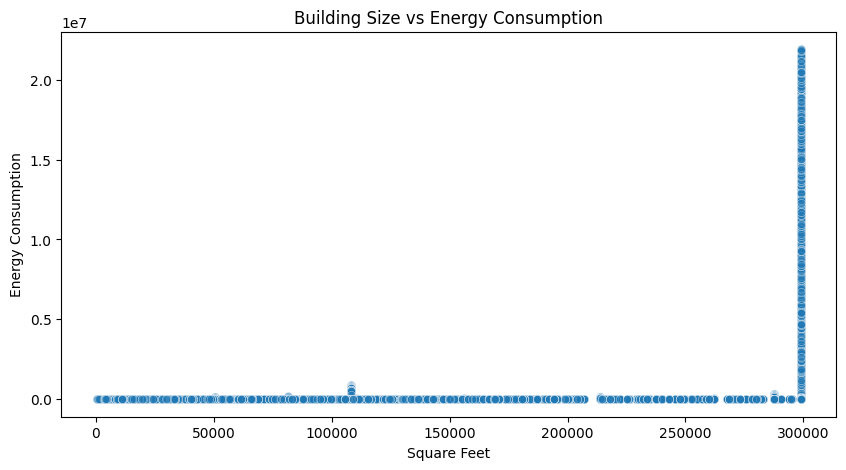

In [42]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['square_feet'], y=df['meter_reading'], alpha=0.5)
plt.title('Building Size vs Energy Consumption')
plt.xlabel('Square Feet')
plt.ylabel('Energy Consumption')
plt.show()


This plot shows the relationship between building size, measured in square feet, and energy consumption. Most buildings are on the smaller side, with relatively low energy consumption. However, there is a huge concentration of data points at the maximum building size, around 300,000 square feet, which also corresponds to high energy consumption. This suggests that larger buildings tend to have higher energy demands, that are likely due to increased space to heat, cool, and light. The plot indicates that while most buildings are smaller and consume less energy, the largest buildings significantly impact overall energy usage, highlighting the importance of size in energy consumption patterns.

However, it is important to mention that this important increase at 300 000 square feet looks a bit abnormal because there is no clear and progressive relation with energy consumption, it is just a huge jump.

### 4-Time-Based Energy Consumption Patterns

**Hourly Consumption by Day of the Week**

C:\Users\lorra\AppData\Local\Temp\ipykernel_30044\333979259.py:1: FutureWarning: The provided callable <function mean at 0x000001E1FEDD31A0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = df.pivot_table(index='hour', columns='dayofweek', values='meter_reading', aggfunc=np.mean)


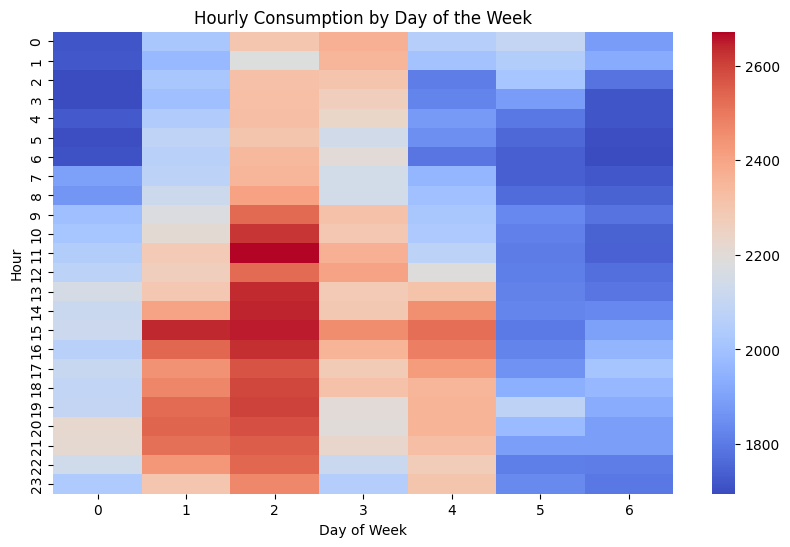

In [44]:
pivot_table = df.pivot_table(index='hour', columns='dayofweek', values='meter_reading', aggfunc=np.mean)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='coolwarm')
plt.title('Hourly Consumption by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()


This heatmap visualizes the average hourly energy consumption across different days of the week, revealing some interesting patterns. The color intensity indicates the level of energy usage, when it is red, it represents higher consumption and bluer cells show lower consumption.

The chart shows that energy consumption tends to be higher during the middle of the week, particularly on days 2 and 3 (likely representing Tuesday and Wednesday). During these days, there's a noticeable peak in energy use around the middle of the day, suggesting increased activity or operational demands. In contrast, the weekends (days 5 and 6) generally show lower energy consumption, with more blue shades indicating reduced activity.

Overall, this heatmap highlights how energy usage varies not only by the time of day but also by the day of the week, with clear distinctions between weekdays and weekends.

**Weekend vs. WeekDay Consumption**

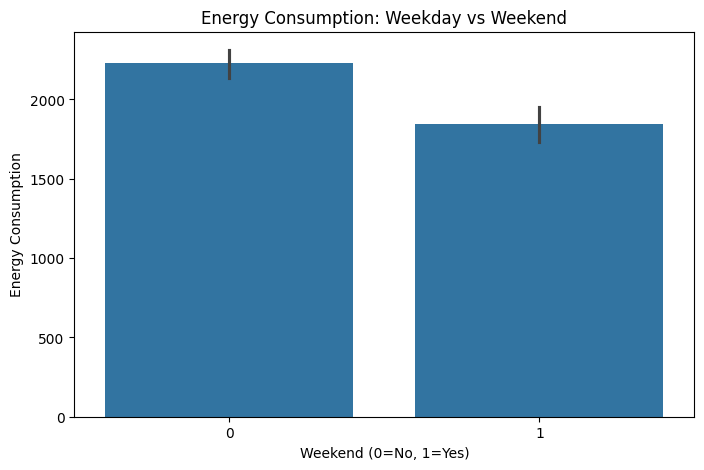

In [45]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['is_weekend'], y=df['meter_reading'])
plt.title('Energy Consumption: Weekday vs Weekend')
plt.xlabel('Weekend (0=No, 1=Yes)')
plt.ylabel('Energy Consumption')
plt.show()


This chart compares energy consumption between weekdays and weekends. The chart shows that energy usage is slightly higher on weekdays (represented by 0) compared to weekends (represented by 1). This suggests that during the week, there might be more activities or operations that require energy, such as work-related activities, while weekends have a slight decrease, possibly due to reduced occupancy or operations in buildings. The difference is not huge, but it does indicate a certain pattern in energy use based on the day type.

## Prediction Models

**Preprocessing Pipeline**

Since our dataset has categorical and numerical variables, we create a pipeline that encodes categorical variables and standardizes numerical features (on continuous numerical data). We need to apply this transformation before fitting any model.

We also apply the log function to our dataset because as we saw there are a few buildings that take up most of the energy consumption and this can make the models less performant.

In [13]:
from sklearn.preprocessing import  OrdinalEncoder

categorical_cols = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]
numerical_cols = ["square_feet", "year_built", "air_temperature", "cloud_coverage","dew_temperature"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)
    ])

# df = df[[categorical_cols + numerical_cols + ['meter_reading', 'date']]]
print(df.columns)

subset_df = df.sample(frac=0.1, random_state=42)

X = subset_df[categorical_cols + numerical_cols]
y = subset_df['meter_reading']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'primary_use', 'date', 'hour', 'year',
       'month', 'day', 'weekend', 'dayofweek', 'is_weekend', 'season',
       'is_hot_day', 'is_cold_day', 'hour_sin', 'hour_cos', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos'],
      dtype='object')


### Regression Models for Energy Prediction

**Linear Regression**

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train)
y_pred_lin = lin_reg.predict(X_test_transformed)
lin_rmse=mean_squared_error(y_test, y_pred_lin, squared=False)
r2_lin=r2_score(y_test, y_pred_lin)
print(f"Linear Regression RMSE: {lin_rmse:.4f}\nLinear Regression R2 Score: {r2_lin}")

Linear Regression MSE: 1.9485
Linear Regression R2 Score: 0.17711097380346985


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Random Forest Regressor**

In [49]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_transformed, y_train)
y_pred_rf = rf.predict(X_test_transformed)
rf_rmse=mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf=r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.4F}\nRandom Forest R2 Score: {r2_rf}")

Random Forest RMSE: 0.6201
Random Forest R2 Score: 0.9166632338105053


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Gradient Boosting**

In [50]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_transformed, y_train)
y_pred_gb = gb_model.predict(X_test_transformed)
gb_rmse = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb=r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting RMSE: {gb_rmse:.4f}\nGradient Boosting R2 Score: {r2_gb}")

Gradient Boosting RMSE: 1.6075
Gradient Boosting R2 Score: 0.4399352496542247


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**XGBoost**

In [51]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_transformed, y_train)
y_pred_xgb = xgb_model.predict(X_test_transformed)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb=r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.4f}\nXGBoost R2 Score: {r2_xgb}")

XGBoost RMSE: 1.3179
XGBoost R2 Score: 0.6235259511650875


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**LightGBM**

In [52]:
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train_transformed, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_transformed)
lgbm_rmse = mean_squared_error(y_test, y_pred_lgbm, squared=False)
r2_lgbm=r2_score(y_test, y_pred_lgbm)
print(f"LightGBM RMSE: {lgbm_rmse:.4f}\nLightGBM R2 Score: {r2_lgbm}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 1617288, number of used features: 12
[LightGBM] [Info] Start training from score 4.145646
LightGBM RMSE: 1.3062
LightGBM R2 Score: 0.6302074750950012


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**CatBoost**

In [53]:
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42)
cat_model.fit(X_train_transformed, y_train)
y_pred_cat = cat_model.predict(X_test_transformed)
cat_rmse = mean_squared_error(y_test, y_pred_cat, squared=False)
r2_cat=r2_score(y_test, y_pred_cat)
print(f"CatBoost RMSE: {cat_rmse:.4f}\nCatBoost R2 Score: {r2_cat}")

CatBoost RMSE: 1.4562
CatBoost R2 Score: 0.5403626952448994


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
rmse_results = {
    "Linear Regression": lin_rmse,
    "Random Forest Regressor": rf_rmse,
    "Gradient Boosting": gb_rmse,
    "XGBoost": xgb_rmse,
    "LightGBM": lgbm_rmse,
    "CatBoost": cat_rmse
}

r2_results = {
    "Linear Regression": r2_lin,
    "Random Forest Regressor": r2_rf,
    "Gradient Boosting": r2_gb,
    "XGBoost": r2_xgb,
    "LightGBM": r2_lgbm,
    "CatBoost": r2_cat
}

sorted_rmse = sorted(rmse_results.items(), key=lambda x: x[1])
for model, rmse in sorted_rmse:
    print(f"{model}: RMSE = {rmse:.4f}")

print("\n")

sorted_r2 = sorted(r2_results.items(), key=lambda x: -x[1])
for model, r2 in sorted_r2:
    print(f"{model}: R2 = {r2:.4f}")

Random Forest Regressor: RMSE = 0.6201
LightGBM: RMSE = 1.3062
XGBoost: RMSE = 1.3179
CatBoost: RMSE = 1.4562
Gradient Boosting: RMSE = 1.6075
Linear Regression: RMSE = 1.9485


Random Forest Regressor: R2 = 0.9167
LightGBM: R2 = 0.6302
XGBoost: R2 = 0.6235
CatBoost: R2 = 0.5404
Gradient Boosting: R2 = 0.4399
Linear Regression: R2 = 0.1771


During our testing, three models really stood out: Random Forest Regressor, LightGBM, and XGBoost. The Random Forest Regressor did amazingly well with an RMSE of 0.6201 and an R² score of 0.9167, showing it's a great fit for the data. LightGBM and XGBoost were also solid, with RMSE scores around 1.3 and R² scores near 0.62-0.63. These are the ones we'll focus on for hyperparameter tuning to make them even better.

The other models, like CatBoost, Gradient Boosting, and Linear Regression, didn't perform as well. Their higher RMSE and lower R² scores mean they're not as reliable for predictions. So, we'll set these aside and concentrate on improving the top models.

### **Hyperparameter Tuning**
The best 3 models are `random forest regressor`, `Light LGBM` and `XGBoost`. We will tune the hyperparameters of these models to improve their performance.

### Random Forest Regressor
For this model, it's very very long to run the hyperparameter tuning. Here is the code to run it, but we will not run it in this notebook.

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    
    score = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_score = np.sqrt(-score)
    
    return np.mean(rmse_score)

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

rf_params = study.best_params
rf_params['random_state'] = 42
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_transformed, y_train)
y_pred_rf = rf.predict(X_test_transformed)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf=r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.4f}\nRandom Forest R2 Score: {r2_rf}")


[I 2025-03-22 16:26:01,658] A new study created in memory with name: no-name-317e51f4-0dee-4fef-950c-882a455cfc1a
[I 2025-03-22 16:49:59,525] Trial 0 finished with value: 1.132103004307115 and parameters: {'n_estimators': 218, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.132103004307115.
[I 2025-03-22 16:57:48,976] Trial 1 finished with value: 1.203693888929973 and parameters: {'n_estimators': 76, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 1.132103004307115.
[I 2025-03-22 17:17:54,012] Trial 2 finished with value: 1.8003021585745302 and parameters: {'n_estimators': 425, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 1.132103004307115.
[I 2025-03-22 17:31:14,397] Trial 3 finished with value: 1.7345189746831555 and parameters: {'n_estimators': 244, 'max_depth': 6, 'min_sam

KeyboardInterrupt: 

### LGBMRegressor

In [ ]:
from sklearn.metrics import root_mean_squared_error


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    
    model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                         colsample_bytree=colsample_bytree, random_state=42)
    
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    
    # return np.mean(rmse)
    return rmse



sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True, )

xgb_params = study.best_params
xgb_params['random_state'] = 42
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_transformed, y_train)
y_pred_xgb = xgb.predict(X_test_transformed)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb=r2_score(y_test, y_pred_xgb)

print(f"LGBMRegressor RMSE: {xgb_rmse:.4f}\nLGBMRegressor R2 Score: {r2_xgb}")


[I 2025-03-22 16:20:15,229] A new study created in memory with name: no-name-923ce854-d2ca-4295-98c5-99af870366e4


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 1617288, number of used features: 12
[LightGBM] [Info] Start training from score 4.145646
[I 2025-03-22 16:20:19,075] Trial 0 finished with value: 1.0896040107695406 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.17524101118128144, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 1.0896040107695406.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points i

c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### XGBRegressor

In [69]:
from sklearn.metrics import root_mean_squared_error


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                         colsample_bytree=colsample_bytree, random_state=42)
    
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    
    # return np.mean(rmse)
    return rmse

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True, )

xgb_params = study.best_params
xgb_params['random_state'] = 42
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_transformed, y_train)
y_pred_xgb = xgb.predict(X_test_transformed)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb=r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse:.4f}\nXGBoost R2 Score: {r2_xgb}")


[I 2025-03-22 15:42:56,368] A new study created in memory with name: no-name-e5c0761d-78dd-4bc8-adab-774919c481c7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-22 15:43:47,600] Trial 0 finished with value: 0.6719720363616943 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.17524101118128144, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 0.6719720363616943.
[I 2025-03-22 15:43:53,569] Trial 1 finished with value: 1.4496688842773438 and parameters: {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.29621516588303487, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 0 with value: 0.6719720363616943.
[I 2025-03-22 15:44:10,057] Trial 2 finished with value: 0.7047707438468933 and parameters: {'n_estimators': 59, 'max_depth': 15, 'learning_rate': 0.2595942550311264, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 0 with value: 0.6719720363616943.
[I 2025-03-22 15:44:18,311] Trial 3 finished with value: 1.3185927867889404 and parameters: {'n_estimators': 132, 'max_depth': 6, 

c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Catboost

In [74]:
# catboost 
from sklearn.metrics import root_mean_squared_error

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    model = CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                         verbose=0, random_state=42)
    
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    
    return rmse

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True, )

cat_params = study.best_params
cat_params['random_state'] = 42
cat = CatBoostRegressor(**cat_params)
cat.fit(X_train_transformed, y_train)
y_pred_cat = cat.predict(X_test_transformed)
cat_rmse = mean_squared_error(y_test, y_pred_cat, squared=False)
r2_cat=r2_score(y_test, y_pred_cat)
print(f"CatBoost RMSE: {cat_rmse:.4f}\nCatBoost R2 Score: {r2_cat}")


[I 2025-03-22 19:55:48,164] A new study created in memory with name: no-name-f844ac30-7717-4f45-95ee-32d249680185


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-22 19:57:25,223] Trial 0 finished with value: 0.8284541766448866 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.17524101118128144, 'subsample': 0.8394633936788146}. Best is trial 0 with value: 0.8284541766448866.
[I 2025-03-22 19:57:35,078] Trial 1 finished with value: 1.8119584509058988 and parameters: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.012551115172973842, 'subsample': 0.9464704583099741}. Best is trial 0 with value: 0.8284541766448866.
[I 2025-03-22 19:58:29,582] Trial 2 finished with value: 1.3974786182645025 and parameters: {'n_estimators': 321, 'max_depth': 12, 'learning_rate': 0.01083858126934475, 'subsample': 0.9879639408647978}. Best is trial 0 with value: 0.8284541766448866.
[I 2025-03-22 19:58:51,416] Trial 3 finished with value: 1.521679341039018 and parameters: {'n_estimators': 425, 'max_depth': 5, 'learning_rate': 0.020366442026830918, 'subsample': 0.6733618039413735}. Best is trial 0 with value: 0.828454176644886

c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Hyperparameter Tuning Summary for Regression Models

|               | RMSE   |       | r2     |       |
|---------------|--------|-------|--------|-------|
|               | before | after | before | after |
| Random Forest | **0.6201** | ~     | **0.92**   | ~     |
| Light LGBM    | 1.31   | **0.70**  | 0.63   | **0.89**  |
| XGBoost       | 1.32   | **0.60**  | 0.62   | **0.92**  |
| Catboost      | 1.46   | **0.69**  | 0.54   | **0.896** |

As we can see after tuning the hyperparameters, the best 2 models are Random Forest and XGBoost with both the lowest RMSE (0.62) and r2 score (0.92). We think that we will prioritize the XGBoost model though, because it is much faster to train and test !

### Clustering and Classification Models for Consumption Patterns and Factors Detection

**K-Means**

To detect peaks in consumption

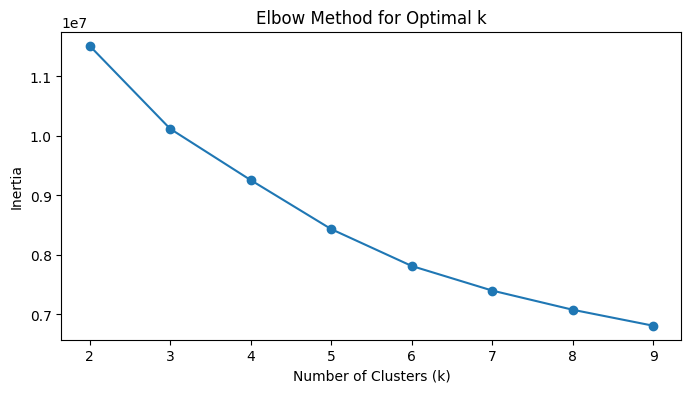

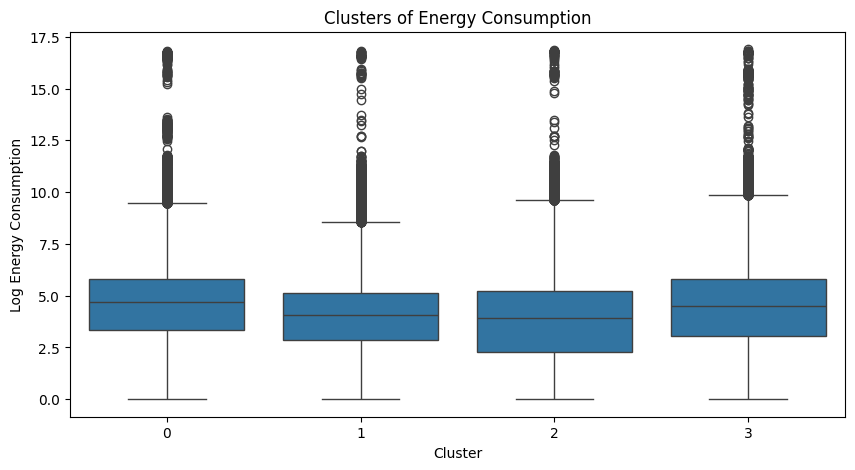

In [ ]:
subset_df['meter_reading_log'] = np.log1p(subset_df['meter_reading'])
features = ['meter_reading_log','air_temperature', 'dew_temperature','cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure','wind_direction','wind_speed']

cluster5_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

X_cluster = cluster5_preprocessor.fit_transform(subset_df[features])

#Finding optimal k using the Elbow method
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
subset_df['cluster'] = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(10, 5))
sns.boxplot(x=subset_df['cluster'], y=subset_df['meter_reading_log'])
plt.xlabel('Cluster')
plt.ylabel('Log Energy Consumption')
plt.title('Clusters of Energy Consumption')
plt.show()

In [71]:
numeric_cols = ['meter_reading','meter_reading_log', 'air_temperature', 'dew_temperature','cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure','wind_direction','wind_speed']
cluster_summary = subset_df.groupby('cluster')[numeric_cols].mean()
print(cluster_summary)

         meter_reading  meter_reading_log  air_temperature  dew_temperature  \
cluster                                                                       
0          1931.459595           4.423576        22.856615        15.042438   
1          4097.561035           3.935189        14.934980         8.301844   
2          1523.099243           3.705982        16.861399         6.937408   
3          3099.414551           4.301091         4.092156        -3.264198   

         cloud_coverage  precip_depth_1_hr  sea_level_pressure  \
cluster                                                          
0              1.591856                0.0         1015.513499   
1              6.948699                0.0         1015.416589   
2              1.750607                0.0         1012.158045   
3              1.179037                0.0         1022.212276   

         wind_direction  wind_speed  
cluster                              
0            111.925499    2.263393  
1            1

In looking at energy consumption patterns across clusters, we noticed some key trends:

- **Cluster 0** has the highest energy use, with an average meter reading of 1931.46. It's also the warmest, with air and dew temperatures around 22.86°C and 15.04°C, suggesting more cooling is needed. Moderate cloud coverage and mild wind speeds might add to this demand.

- **Cluster 1** also consumes a lot of energy, with a meter reading of 4097.56. Despite cooler temperatures (14.93°C air, 8.30°C dew), high cloud coverage (6.95) could mean more artificial lighting and heating are needed.

- **Cluster 2** uses the least energy, with a reading of 1523.10. Moderate temperatures (16.86°C air, 6.94°C dew) and low cloud coverage (1.75) suggest a more energy-efficient setup, possibly aided by higher wind speeds (4.87 m/s) for natural cooling.

- **Cluster 3** has moderate energy use (3099.41) but is the coldest, with temperatures around 4.09°C air and -3.26°C dew. Clear, stable weather with high sea level pressure (1022.21) and low cloud coverage (1.18) likely increases heating needs.

Overall, temperature, cloud coverage, and wind speed all affect energy consumption, with warmer or cloudier conditions generally leading to higher energy use.

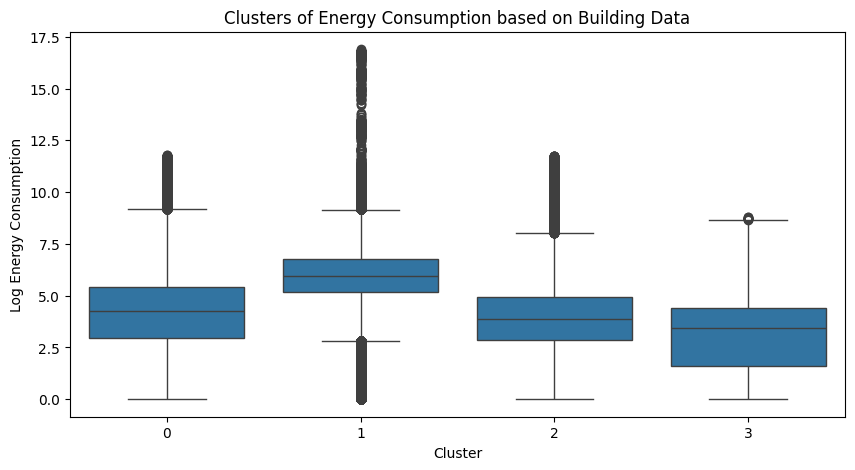

In [ ]:
building_features = ['meter_reading_log','square_feet', 'year_built', 'primary_use', 'building_id']

# Preprocessing the features
building_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['meter_reading_log','square_feet', 'year_built']),  
        ('cat', OrdinalEncoder(), ['primary_use']) 
    ]
)


X_building = building_preprocessor.fit_transform(subset_df[building_features])


kmeans_building = KMeans(n_clusters=4, random_state=42, n_init=10)
subset_df['cluster'] = kmeans_building.fit_predict(X_building)


plt.figure(figsize=(10, 5))
sns.boxplot(x=subset_df['cluster'], y=subset_df['meter_reading_log'])
plt.xlabel('Cluster')
plt.ylabel('Log Energy Consumption')
plt.title('Clusters of Energy Consumption based on Building Data')
plt.show()

In [ ]:
numerical_summary = subset_df.groupby('cluster')[['meter_reading', 'meter_reading_log','square_feet', 'year_built']].mean()

categorical_summary = subset_df.groupby('cluster')[['primary_use', 'building_id']].agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([numerical_summary, categorical_summary], axis=1)

print("Cluster Summary Based on Building Data:")
print(cluster_summary)


Cluster Summary Based on Building Data:
         meter_reading  meter_reading_log    square_feet   year_built  \
cluster                                                                 
0           423.572968           4.040989   85231.539441  1968.982056   
1          8860.946289           5.923048  177969.952260  1974.456055   
2           408.799805           3.896314   89304.030266  1969.553101   
3            66.223709           3.019314   57119.658590  1962.292725   

             primary_use  building_id  
cluster                                
0                 Office         1295  
1              Education         1298  
2        Public services          206  
3              Education          948  


Energy consumption is definitely higher in larger buildings, especially in Cluster 1, which averages around 177,970 square feet and has the highest energy use (meter reading of 8860.95). These buildings, mostly used for education, are likely more energy-intensive due to higher occupancy and extensive use of systems like heating and lighting.

On the other hand, Cluster 3 includes smaller buildings, averaging 57,120 square feet, with the lowest energy consumption (meter reading of 66.22). These buildings, also used for education, seem more energy-efficient, possibly due to their smaller size or recent energy-saving renovations, despite being older (built around 1962).

Cluster 0 has moderate energy use with buildings averaging 85,232 square feet, typically used as offices. These buildings, while smaller than those in Cluster 1, still consume a fair amount of energy, likely due to high operational demands.

Cluster 2 includes medium-sized buildings (89,304 square feet) used for public services, showing relatively low energy consumption. This suggests these buildings might be more energy-efficient or have lower operational needs.

In summary, building size and use, especially for education, significantly impact energy consumption. Larger buildings tend to use more energy, while smaller ones are often more efficient.

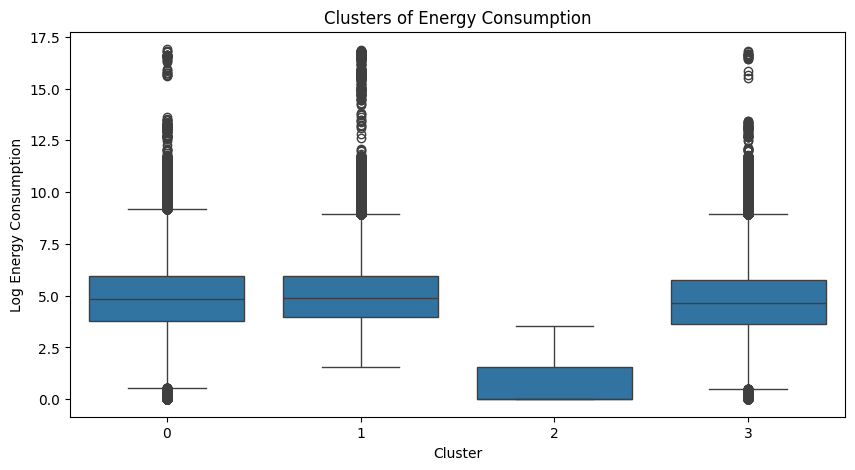

In [ ]:
features = ['meter_reading_log','hour', 'dayofweek', 'month']

cluster3_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

X_cluster = cluster3_preprocessor.fit_transform(subset_df[features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
subset_df['cluster'] = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(10, 5))
sns.boxplot(x=subset_df['cluster'], y=subset_df['meter_reading_log'])
plt.xlabel('Cluster')
plt.ylabel('Log Energy Consumption')
plt.title('Clusters of Energy Consumption')
plt.show()

In [77]:
numeric_cols = ['meter_reading','meter_reading_log', 'hour', 'dayofweek', 'month']
cluster_summary = subset_df.groupby('cluster')[numeric_cols].mean()
print(cluster_summary)

         meter_reading  meter_reading_log       hour  dayofweek     month
cluster                                                                  
0          1424.190308           4.904032  17.864569   2.983335  9.023838
1          5530.515625           5.024797  12.129845   2.933325  2.939728
2             2.750149           0.769962  11.031360   3.209660  5.682835
3           981.271301           4.754101   4.947665   2.972286  8.734474


- **Cluster 0**: Shows moderate energy use, peaking around 6 PM, with higher consumption in September. This suggests evening activity and possibly higher fall or late summer usage.

- **Cluster 1**: Has the highest energy consumption, especially around noon and in February. This could be due to colder weather or increased midday activities.

- **Cluster 2**: Uses the least energy, mostly in the morning around 11 AM, with a peak in May. This might indicate fewer activities or more efficient buildings during this time.

- **Cluster 3**: Shows moderate energy use, peaking around 5 PM, with the highest usage in August. This could be due to summer cooling needs.

**Conclusion**

- **Time of Day**: Clusters 0 and 3 use more energy in the evening or afternoon, while Cluster 1 peaks at midday, and Cluster 2 is lowest in the morning.

- **Month**: Cluster 1 spikes in February, Cluster 0 in September, Cluster 2 in May, and Cluster 3 in August, showing seasonal variations in energy use.

These patterns suggest that energy consumption is influenced by the time of day and month, with certain times and seasons seeing higher demand.

### Conclusion: Key Factors Influencing Energy Consumption in Buildings


Several factors play a big role in how much energy buildings use, including the environment, building size, primary function, and time of day or year.  

1. **Environmental Factors**:  
   - **Temperature** has a major impact—warmer climates (like **Cluster 0**) see higher energy use due to cooling needs.  
   - **Cloud coverage & wind speed** matter too. **Cluster 1** buildings use more energy on cloudy days (more lighting/heating), while **Cluster 2** benefits from natural cooling with stronger winds.  
   - **Dew temperature** affects humidity control, increasing cooling demand when moisture levels rise.  

2. **Building Size & Use**:  
   - **Larger buildings** (especially in **Cluster 1**) consume more energy, mainly due to heating and lighting for bigger spaces.  
   - **Education buildings** tend to be more energy-intensive, while **Public Services** buildings (Cluster 2) use less, likely due to more efficient operations.  

3. **Time & Seasonality**:  
   - Energy use peaks vary—**Cluster 0 & 3** see more demand in the afternoon/evening, while **Cluster 1** peaks midday (possibly due to school hours).  
   - Seasonal trends also play a role: **Cluster 1** spikes in **February** (heating), **Cluster 3** in **August** (cooling), and **Cluster 0** in **September** (late summer). **Cluster 2** sees the lowest usage in **May** (mild weather).  

#### Insights:  
- **Weather conditions** significantly impact energy use.  
- **Bigger buildings**, especially **schools**, tend to consume more energy.  
- **Time of day and seasonality** influence demand, with peaks linked to heating and cooling needs.  

By recognizing these patterns, building managers can plan better and reduce unnecessary energy consumption.